In [1]:
%matplotlib inline
from matplotlib import pylab as plt
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (15.0, 8.0)
import pandas as pd
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [22]:
# # from bokeh.charts import TimeSeries, output_file, show
# from bokeh.plotting import output_file, show
# from bokeh.io import output_notebook
# output_notebook()

### Data Preparation
Eleven months data from one bed one bath apartment unit in San Jose, CA region was picked for this experiment. The electricity consumption is recorded in 15 minutes interval by the energy supply company. The raw data contains information such as type, date, start time, end time, usage, units, cost and notes fields. The start time and end time is the measurement interval. In this data, the interval is 15 minutes. The usage in 15 minutes interval is provided in kWh unit, and the cost for the consumption is presented in the dollar. Before we deep dive into the data, some quick feature engineering steps are done to enrich the data with more features. 

In [25]:
data = pd.read_csv("D202.csv")
data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN


In [26]:
data.shape

(31864, 8)

#### Creating Date and Time Filed

In [27]:
data["DATE_TIME"] = pd.to_datetime(data.DATE + " " + data["END TIME"])

data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN,2016-11-01 00:14:00
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN,2016-11-01 00:29:00


#### Working Day or Not

In [28]:
data["DAY_TYPE"] = data.DATE_TIME.apply(lambda x: 1 if x.dayofweek > 5 else 0  )

data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN,2016-11-01 00:14:00,0
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN,2016-11-01 00:29:00,0


#### Finding Fedaral Holidays

In [29]:
cal = calendar()
holidays = cal.holidays(start = data.DATE_TIME.min(), end = data.DATE_TIME.max())
data["IS_HOLIDAY"] = data.DATE_TIME.isin(holidays)

data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN,2016-11-01 00:14:00,0,False
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN,2016-11-01 00:29:00,0,False


#### Previous Five Observations

In [30]:
for obs in range(1,6):
    data["T_" + str(obs)] = data.USAGE.shift(obs) #right shift[ y(t-1), y(t-2), y(t-3), y(t-4), y(t-5)]

In [31]:
data.fillna(0.00,inplace=True)
data.head(10)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,0,2016-11-01 00:14:00,0,False,0.00,0.00,0.00,0.00,0.00
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,0,2016-11-01 00:29:00,0,False,0.07,0.00,0.00,0.00,0.00
2,Electric usage,11/1/16,0:30,0:44,0.06,kWh,$0.01,0,2016-11-01 00:44:00,0,False,0.05,0.07,0.00,0.00,0.00
3,Electric usage,11/1/16,0:45,0:59,0.05,kWh,$0.01,0,2016-11-01 00:59:00,0,False,0.06,0.05,0.07,0.00,0.00
4,Electric usage,11/1/16,1:00,1:14,0.03,kWh,$0.01,0,2016-11-01 01:14:00,0,False,0.05,0.06,0.05,0.07,0.00
5,Electric usage,11/1/16,1:15,1:29,0.03,kWh,$0.01,0,2016-11-01 01:29:00,0,False,0.03,0.05,0.06,0.05,0.07
6,Electric usage,11/1/16,1:30,1:44,0.03,kWh,$0.01,0,2016-11-01 01:44:00,0,False,0.03,0.03,0.05,0.06,0.05
7,Electric usage,11/1/16,1:45,1:59,0.06,kWh,$0.01,0,2016-11-01 01:59:00,0,False,0.03,0.03,0.03,0.05,0.06
8,Electric usage,11/1/16,2:00,2:14,0.04,kWh,$0.01,0,2016-11-01 02:14:00,0,False,0.06,0.03,0.03,0.03,0.05
9,Electric usage,11/1/16,2:15,2:29,0.03,kWh,$0.01,0,2016-11-01 02:29:00,0,False,0.04,0.06,0.03,0.03,0.03


In [32]:
data.IS_HOLIDAY = data.IS_HOLIDAY.astype("int")

In [33]:
data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,0,2016-11-01 00:14:00,0,0,0.00,0.0,0.0,0.0,0.0
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,0,2016-11-01 00:29:00,0,0,0.07,0.0,0.0,0.0,0.0


#### Clean Data

In [34]:
clean_data = data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]

In [35]:
clean_data.head(2)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
0,0,0,0.00,0.0,0.0,0.0,0.0,0.07
1,0,0,0.07,0.0,0.0,0.0,0.0,0.05


### Let's Explore

In [42]:
# Function to plot TS

def plot_TS(df, date_col_name, target_col_name, out_notebook=True):
    from bokeh.models import ColumnDataSource
    from bokeh.plotting import figure, show, output_file
    # from bokeh.io import show, output_notebook
    from bokeh.io import output_notebook
    %matplotlib inline
    
    source = ColumnDataSource(df)

    p = figure(x_axis_type="datetime", plot_width=800, plot_height=350)
    p.line(date_col_name, target_col_name, source=source)

    if out_notebook:
        # Set to output the plot in the notebook
        output_notebook()
    else:
        # To see output in new tab
        output_file("ts.html")

    show(p)
    
#plot_TS(df, 'Date', 'Precision')

In [43]:
# all_show = TimeSeries(data,x="DATE_TIME",y=["USAGE"],legend=True,plot_width=900, plot_height=350)
# show(all_show)

plot_TS(data, 'DATE_TIME', 'USAGE')

ValueError: expected an element of either String, Dict(Enum('expr', 'field', 'value', 'transform'), Either(String, Instance(Transform), Instance(Expression), List(String))) or List(String), got True

### A Week ! Yes X'Mas Week

In [16]:
xmask = (data.DATE_TIME >= pd.to_datetime("12/20/2016")) & (data.DATE_TIME <= pd.to_datetime("12/27/2016"))

In [17]:
xmas_week = data.loc[xmask]

In [18]:
xmas_show = TimeSeries(xmas_week,x="DATE_TIME",y=["USAGE"],legend=True,plot_width=900, plot_height=350)
show(xmas_show)

### A Day ! New Year 2017

In [19]:
dmask = (data.DATE_TIME >= pd.to_datetime("01/01/2017")) & (data.DATE_TIME < pd.to_datetime("01/02/2017"))
nyd = data.loc[dmask]

In [20]:
nyd_show = TimeSeries(nyd,x="DATE_TIME",y=["USAGE"],legend=True,plot_width=900, plot_height=350)
show(nyd_show)

### Train and Test Data

In [21]:
training_data = data[data.DATE_TIME < pd.to_datetime("08/01/2017")]

In [22]:
val_mask = (data.DATE_TIME >= pd.to_datetime("08/01/2017")) & (data.DATE_TIME < pd.to_datetime("09/01/2017"))
val_data = data.loc[val_mask]

In [23]:
test_data = data[data.DATE_TIME >= pd.to_datetime("09/01/2017")]

In [24]:
training_data.tail(3)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
26006,Electric usage,7/31/17,23:15,23:29,0.12,kWh,$0.02,0,2017-07-31 23:29:00,0,0,0.15,0.10,0.27,0.44,0.12
26007,Electric usage,7/31/17,23:30,23:44,0.11,kWh,$0.02,0,2017-07-31 23:44:00,0,0,0.12,0.15,0.10,0.27,0.44
26008,Electric usage,7/31/17,23:45,23:59,0.10,kWh,$0.02,0,2017-07-31 23:59:00,0,0,0.11,0.12,0.15,0.10,0.27


In [25]:
test_data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
28984,Electric usage,9/1/17,0:00,0:14,0.03,kWh,$0.01,0,2017-09-01 00:14:00,0,0,0.03,0.03,0.04,0.04,0.05
28985,Electric usage,9/1/17,0:15,0:29,0.04,kWh,$0.01,0,2017-09-01 00:29:00,0,0,0.03,0.03,0.03,0.04,0.04


In [26]:
clean_train = training_data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]
clean_test = test_data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]
clean_val = val_data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]

In [27]:
clean_train.head(2)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
0,0,0,0.00,0.0,0.0,0.0,0.0,0.07
1,0,0,0.07,0.0,0.0,0.0,0.0,0.05


In [28]:
clean_test.head(2)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
28984,0,0,0.03,0.03,0.04,0.04,0.05,0.03
28985,0,0,0.03,0.03,0.03,0.04,0.04,0.04


In [29]:
clean_val.head(3)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
26009,0,0,0.1,0.11,0.12,0.15,0.10,0.10
26010,0,0,0.1,0.10,0.11,0.12,0.15,0.10
26011,0,0,0.1,0.10,0.10,0.11,0.12,0.08


### Let's Model and Predict

In [30]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

In [31]:
X_train,y_train = clean_train.drop(["USAGE"],axis=1),clean_train.USAGE
X_test,y_test = clean_test.drop(["USAGE"],axis=1),clean_test.USAGE
X_val,y_val = clean_val.drop(["USAGE"],axis=1),clean_val.USAGE

In [32]:
scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1, 1))
rfr  = RandomForestRegressor(random_state=2017,verbose=2,n_jobs=5)

In [33]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_valid_scaled = scaler.fit_transform(X_val)

In [34]:
rfr.fit(X_train_scaled,y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=5,
           oob_score=False, random_state=2017, verbose=2, warm_start=False)

In [35]:
rfr.score(X_val,y_val)

[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.0s finished


0.26352935135691857

In [36]:
rfr.score(X_test,y_test)

[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.0s finished


0.32707009777378615

In [37]:
test_data["RF_PREDICTED"] = rfr.predict(X_test_scaled)

[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.0s finished
/Users/jagan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [38]:
test_data.head(5)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,RF_PREDICTED
28984,Electric usage,9/1/17,0:00,0:14,0.03,kWh,$0.01,0,2017-09-01 00:14:00,0,0,0.03,0.03,0.04,0.04,0.05,0.021306
28985,Electric usage,9/1/17,0:15,0:29,0.04,kWh,$0.01,0,2017-09-01 00:29:00,0,0,0.03,0.03,0.03,0.04,0.04,0.060113
28986,Electric usage,9/1/17,0:30,0:44,0.06,kWh,$0.01,0,2017-09-01 00:44:00,0,0,0.04,0.03,0.03,0.03,0.04,0.048081
28987,Electric usage,9/1/17,0:45,0:59,0.03,kWh,$0.01,0,2017-09-01 00:59:00,0,0,0.06,0.04,0.03,0.03,0.03,0.061000
28988,Electric usage,9/1/17,1:00,1:14,0.03,kWh,$0.01,0,2017-09-01 01:14:00,0,0,0.03,0.06,0.04,0.03,0.03,0.028246


### Prediction with Random Forest Model in Test Data

In [39]:
pred_show = TimeSeries(test_data,x="DATE_TIME",y=["USAGE","RF_PREDICTED"],legend=True,plot_width=800, plot_height=350)
show(pred_show)

#### Prediction Single Day in Test Data

In [40]:
sep_30m = test_data[test_data.DATE_TIME >= pd.to_datetime("09/30/2017")]

sep_30rf = TimeSeries(sep_30m,x="DATE_TIME",y=["USAGE","RF_PREDICTED"],legend=True,plot_width=900, plot_height=350)
show(sep_30rf)

### LSTM Modelling

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#### LSTM Model

In [42]:
model_k = Sequential()
model_k.add(LSTM(1, input_shape=(1,7)))
model_k.add(Dense(1))
model_k.compile(loss='mean_squared_error', optimizer='adam')

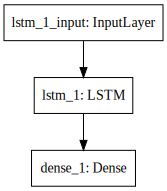

In [43]:
SVG(model_to_dot(model_k).create(prog='dot', format='svg'))

#### Reshape the data to 3D

In [44]:
X_t_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [45]:
X_val_resaped = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))

##### Fit the Model

In [46]:
history = model_k.fit(X_t_reshaped, y_train, validation_data=(X_val_resaped, y_val),\
epochs=10, batch_size=96, verbose=2)

Train on 26009 samples, validate on 2975 samples
Epoch 1/10
2s - loss: 0.0757 - val_loss: 0.0165
Epoch 2/10
1s - loss: 0.0605 - val_loss: 0.0191
Epoch 3/10
1s - loss: 0.0506 - val_loss: 0.0166
Epoch 4/10
1s - loss: 0.0421 - val_loss: 0.0207
Epoch 5/10
1s - loss: 0.0370 - val_loss: 0.0267
Epoch 6/10
1s - loss: 0.0339 - val_loss: 0.0307
Epoch 7/10
1s - loss: 0.0321 - val_loss: 0.0357
Epoch 8/10
1s - loss: 0.0309 - val_loss: 0.0394
Epoch 9/10
1s - loss: 0.0303 - val_loss: 0.0396
Epoch 10/10
1s - loss: 0.0298 - val_loss: 0.0413


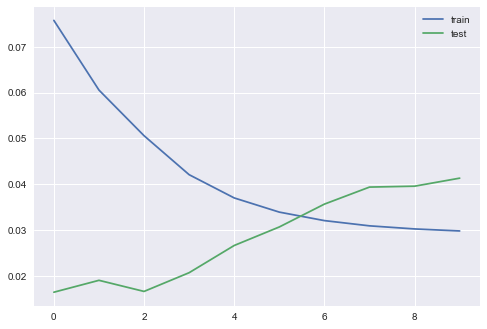

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [48]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [49]:
res = model_k.predict(X_te_reshaped)

In [50]:
test_data["DL_PRED"] = res

/Users/jagan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### LSTM Prediction on Test Data

In [51]:
keras_show = TimeSeries(test_data,x="DATE_TIME",y=["USAGE","RF_PREDICTED","DL_PRED"],legend=True,plot_width=900, plot_height=350)
show(keras_show)

#### A Day on LSTM Predcted Result

In [52]:
sep_30m = test_data[test_data.DATE_TIME >= pd.to_datetime("09/30/2017")]

sep_30 = TimeSeries(sep_30m,x="DATE_TIME",y=["USAGE","RF_PREDICTED","DL_PRED"],legend=True,plot_width=900, plot_height=350)
show(sep_30)

#### RMSE Value of Random Forest and LSTM

In [53]:
from numpy import sqrt
sqrt(mean_squared_error(test_data.USAGE,test_data.DL_PRED))

0.16743906314666301

In [54]:
sqrt(mean_squared_error(test_data.USAGE,test_data.RF_PREDICTED))

0.18412616700088405

# ref

https://www.youtube.com/watch?v=d_qX2V9iBeQ

https://github.com/jaganadhg/LSTM_Electricity_01